<h1><center>Guide Notebook for the 380CT Assignment on TSP</center></h1>

# Authors

Vilius Zurauskas

Lukas Balta

Aleksandras Asavkinas

Rokas Labanauskas

Everything up to Metaheuristics section is taken from "Investigating TSP.ipynb" made by _Kamal Bentahar_

https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance/blob/master/Investigating%20TSP.ipynb

# Notation and definitions

Let $G$ be a complete weighted graph with $n$ vertices...

- **Complete**: the graph is undirected, has no self-loops, and each node is connected to all the other vertices.
- **Weighted**: the edges have a weight (a positive integer).
- **Cycle**: a path that visits every vertex once, and goes back to the start point.
- **Total cost of the cycle**: sum of the edge weights of the cycle.

# Definition of the problem

Given $G$ as above, the versions of the TSP are defined as follows:

* **Decisional TSP (D-TSP)**:
> Given a total cost $k$, decide if $G$ is has a cycle of length $\leq k$.

    **NP-complete**, because D-TSP $\in$ NP and D-TSP $\leq_p$ HAMCYCLE.
    
    * D-TSP $\in$ NP: once a cycle is given (a certificate) we can quickly evaluate the its cost in $O(n)$ time to verify it is equal to $k$.
    * D-TSP $\leq_p$ HAMCYCLE: Reduction from HAMCYCLE (Hoos and Stutzler, p.25).

* **Search TSP**:
> Given a total cost $k$, search for a cycle of length $\leq k$ in $G$.
> (If found then return it, otherwise say that there is no such cycle.)
    
* **Optimization TSP**:
> Given $G$, find a cycle of minimal total cost.

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search TSP**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979) and (Hoos and Stutzler, 2005).

# Testing methodology

* **Exact methods**:
    Average time for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average "quality" as $n$ increases.


## Random instances sampling strategy

General TSP instances will be generated by creating symmetric adjacency matrices uniformly at random.

# Code

First start by importing relevant libraries.

In [2]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from math import isinf
from time      import time
import matplotlib.pyplot as plt
import copy

## Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

Without loss of generality, we can consider $0$ to be the start and end point of cycles.

In [3]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c        

G=random_euclidean_graph(5)
show(G)

### Example

In [3]:
G=random_symmetric_graph(5)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  51  96  34  58
 1 |   51   ∞  95  86  69
 2 |   96  95   ∞  78  75
 3 |   34  86  78   ∞  95
 4 |   58  69  75  95   ∞



# Solution methods

## Exact methods - Exhaustive search

The idea is to:
- Consider vertex $0$ as the start and end point.
- Iterate over all permutations of the vertices $\{1,2,\ldots, n-1\}$.
    -  Calculate cost of each permutation and keep track of minimum cost permutation.
- Return the cycle with minimum cost.

More formally, the pseudo-code is as follows:

**Input**: $G$.

**Output**: a cycle in $G$ of shortest cost.

1. $bestcycle\gets \emptyset$
2. $bestcost\gets \infty$
3. **for all** possible cycles $p$ in $G$ (starting and ending at $0$) **do**
4. $\quad$ $c\gets$ cost of $p$
2. $\quad$ **if** $c<bestcost$ **then**
3. $\qquad$ $bestcycle\gets p$
3. $\qquad$ $bestcost\gets c$
4. $\quad$ **end if**
5. **end for**
6. **return** $bestcycle, bestcost$

There are $(n-1)!$ possible cycles, and each computation of a cycle's cost costs $O(n)$. So this algorithm costs $$O((n-1)!\cdot n)=O(n!).$$

In [4]:
def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n-1]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

## Testing exhaustive search time cost

Test completely random graphs:

In [5]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G = random_symmetric_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.020841598510742188
9	0.17892074584960938
10	1.2077081203460693


Let us plot this data to see it visually.

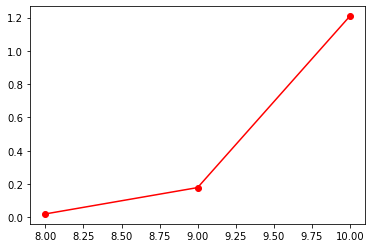

In [6]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

Let us see if the emperical times match the theoretical $O(n!)$ expectation.

`pnts_t[i]` contains the time for `pnts_n[i]`, so we expect $\text{pnts_t[i]} \approx \text{pnts_n[i]}!$.
Hence, we must have

$$
\frac{\text{pnts_t[i]}}{\text{pnts_t[i-1]}} \approx \frac{i!}{(i-1)!} = i.
$$

pnts_ratios = [pnts_t[i]/pnts_t[i-1] for i in range(1,len(pnts_n))]
plt.plot(pnts_n[:-1], pnts_ratios, 'ro-')
plt.plot(pnts_n,pnts_n,'b-') # theoretical ratios
plt.show()

In [7]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G = random_euclidean_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.013912677764892578
9	0.11310958862304688
10	1.0932083129882812


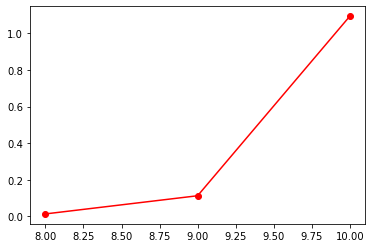

In [8]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

### Discussion

* Exhaustive search exhibits combinatorial running time $O(n!)$:
* So it is only useful/possible when $n$ is small, up to about 13 on the current machine if it needs to finish within an hour.

# Approximation

## Greedy search

##### Nearest neigbours

In [4]:
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))

The while-loop costs $O(n)$, and the nested for-loop within it also costs $O(n)$, while the rest can be assumed to cost $O(1)$.
So the total cost of this greedy approach is $O(n)\times O(n) = O(n^2)$.

### Example

In [10]:
G=random_symmetric_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞  83  49  67
 1 |   83   ∞  22  62
 2 |   49  22   ∞  41
 3 |   67  62  41   ∞



([0, 2, 1, 3], 200)

In [11]:
G=random_euclidean_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞78.644770964127056.32455532033675951.40038910358559
 1 | 78.64477096412705   ∞84.1724420460758652.354560450833695
 2 | 6.32455532033675984.17244204607586   ∞53.75872022286245
 3 | 51.4003891035855952.35456045083369553.75872022286245   ∞



([0, 2, 3, 1], 191.08260695815994)

### Test time and quality cost

We will initially estimate the "quality" simply by comparing the length of the cycle found by the greed approach to the "average length of a random cycle".

The average length of a random cycle is estimated to be the average length of a graph edge multiplied by the number of edges, i.e.

$$\frac{\text{MAX_DISTANCE}}{2} \times n.$$

In [12]:
MAX_REPETITIONS = 500

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<10: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G = random_symmetric_graph(n)
        t0 = time()
        cycle, length = greedy_nearest_neighbours(G)
        t1 = time()
        sum_of_distances += length
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}" )
    n += 10

10	0.10154461860656738	0.498612
20	0.21607756614685059	0.32558800000000004
30	0.43499183654785156	0.243632
40	0.8123703002929688	0.198426
50	1.294175386428833	0.170176
60	1.4665734767913818	0.14905133333333334
70	1.9094252586364746	0.134852
80	2.5196692943573	0.1230035
90	2.9445836544036865	0.11244
100	3.6123154163360596	0.1035828
110	4.4289233684539795	0.09703527272727272
120	5.171190977096558	0.09257666666666667
130	6.0585081577301025	0.0866676923076923
140	6.832968235015869	0.08257714285714285
150	7.999419927597046	0.07939413333333334
160	8.868702173233032	0.07580374999999999
170	10.164819478988647	0.0720155294117647


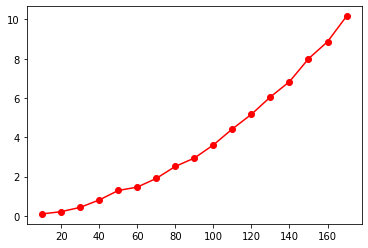

In [13]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

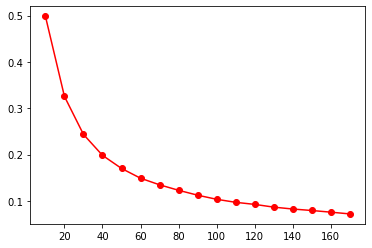

In [14]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

In [15]:
MAX_REPETITIONS = 500

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<5: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = 0.71*sqrt(n) # TODO: Better estimate?
    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G = random_euclidean_graph(n)
        t0 = time()
        cycle, length = greedy_nearest_neighbours(G)
        t1 = time()
        sum_of_distances += length
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}" )
    n += 10

10	0.09403204917907715	141.95026064554747
20	0.18393492698669434	143.34838595021796
30	0.3777341842651367	143.08364669666716
40	0.6234962940216064	141.43121782752903
50	0.9454472064971924	140.8344716240483
60	1.357116937637329	139.1613140539015
70	1.8229765892028809	139.61992536458771
80	2.384805202484131	137.98468665671473
90	2.989745616912842	137.7813719879342
100	3.6056571006774902	138.00338380599055
110	4.298963785171509	137.30927880654804
120	5.128930330276489	137.06045253511863


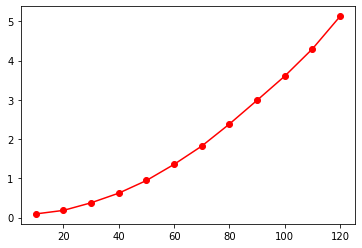

In [16]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

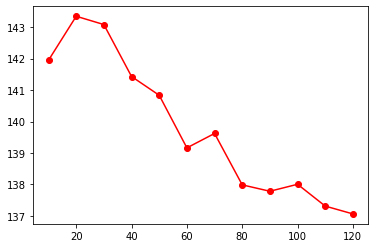

In [17]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

# Metaheuristics

## Simulated annealing

This metaheuristic is used to approximate global optimum using an annealing schedule. The method has been derived from annealing technique in metalurgy. As the metal cool downs it's molecural structure changes, which means that various material properties can be changed via controlled cooling of the metal.

When it comes to solving problems this approach is interpreted as slow decrease in probability to accept worse solutions. Worse solutions are accepted in order to escape the local minimum (In TSP's case) (Kirkpatrick, S.; Gelatt, C. D.; Vecchi, M. P., 1983).

The generic pseudocode template for TSP is:

**Input**: A graph (a list of nodes, each list containing list of distances from node to node)

**Output**: A path (Solution, starting at one node and visiting all the nodes and finishing at the same one)

1. $current\_solution\gets$ random_solution()
2. **while** $temperature$ > 1 **do**:
3. $\quad$ $neighbour\_solution\gets$ generate_neighbour_solution()
4. $\quad$ **if** $neighbour\_solution$ **is better than** $current\_solution$:
5. $\quad\quad$ $current\_solution\gets neighbour\_solution$
6. $\quad$ **else if** $P(cost(current), cost(neighbour), temperature)$ > randFloat(0, 1)
7. $\quad\quad$ $current\_solution\gets neighbour\_solution$
8. $\quad$ $temperature = temperature\times \Delta temperature$
9. **return** $current\_solution$

More detailed explanation:
- **solution** - Path throughout all the cities starting and ending at the same point (TSP solution)
- **neighbour solution** - Seperate solution that differs by reversing two random points and the path between them.
- **P()** - The function that decides the probability of the worse move to be accepted
- **randFloat(a,b)** - The function that picks a random float between a and b (inclusive)
- $\Delta$**temperature** - The temperature change that is used to cool down and settle towards better solutions

Lines 1-4 are O(1). Line 5 is O(n) because it performs a 2-opt on a list, lines 6-9 are O(1). Our implementation of this metaheuristic runs in **O(n)** time.

### The adapted solution

#### Defining all the needed functions:

The helper functions that are needed for simulated annealing:

In [5]:
from random import shuffle, uniform
from math import exp


In [6]:
def generate_random_solution(G):
    n = len(G)
    randCycle = list(range(n))
    shuffle(randCycle)
    return randCycle

In [7]:
def generate_neighbour_array_reverse(solution):
    solution_current = copy.deepcopy(solution)
    n = len(solution_current)
    first = randint(0, n - 1)
    second = randint(0, n - 1)
    while first == second:
        second = randint(0, n - 1)

    if first > second:
        solution_current[second:first] = solution_current[second:first][::-1]
    else:
        solution_current[first:second] = solution_current[first:second][::-1]

    return solution_current

The probability function that decides if worse solution is taken. The formula for acceptance probability was derived from Boltzmann distribution: 
$$p = exp( \frac{-(new\_cost - cost)}{temperature})$$

In [8]:
def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = exp(- (new_cost - cost) / temperature)
        return p

Simulated annealing function itself. Two of the parameters are changeable, starting temperature and temperature change. The run time depends on both of these.

In [9]:
def simulated_annealing(G, temperature_max=10000, temperature_delta=0.999):
    # Generate current random solution
    solution_current = generate_random_solution(G)
    cost_current = cost(G, solution_current)

    # Initialize variables to keep track of best solution
    solution_best = copy.deepcopy(solution_current)
    cost_best = cost_current

    # Initialize temperature
    temperature = temperature_max
    best_cost_list = []
    temperatureChange = []
    while temperature > 1:
        solution_next = generate_neighbour_array_reverse(solution_current)
        cost_next = cost(G, solution_next)

        # If random swap has a better solution get that as best
        if cost_current > cost_next:
            solution_current = copy.deepcopy(solution_next)
            cost_current = cost_next
            solution_best = copy.deepcopy(solution_next)
            cost_best = cost_next
            best_cost_list.append(cost_best)
        # If the random swap is not the best, use it as the potential next solution
        elif acceptance_probability(cost_current, cost_next, temperature) >= uniform(0, 1):
            solution_current = copy.deepcopy(solution_next)
            cost_current = cost_next

        temperature *= temperature_delta
        temperatureChange.append(temperature)
    return (solution_best, cost_best, temperatureChange, best_cost_list)

### Testing

In [23]:
import matplotlib.pyplot as plt

def see_annealing(temperature, costs):
    plt.figure()
    costPlot = plt.subplot(121)
    plt.plot(costs, 'b')
    costPlot.set_xlabel('Iterations')
    costPlot.set_ylabel('Cost')
    plt.title("Costs")
    tempPlot = plt.subplot(122)
    plt.plot(temperature, 'b')
    plt.title("Temperature")
    tempPlot.set_xlabel('Iterations')
    tempPlot.set_ylabel('Temperature')
    plt.tight_layout()
    plt.show()

In [24]:
G = random_symmetric_graph(30)

resultAnnealing = simulated_annealing(G)
print(resultAnnealing[:2])

([15, 25, 27, 24, 28, 12, 0, 22, 3, 7, 23, 13, 6, 11, 1, 14, 4, 16, 20, 17, 19, 9, 29, 21, 2, 5, 8, 10, 18, 26], 223)


### Visualizing the tests

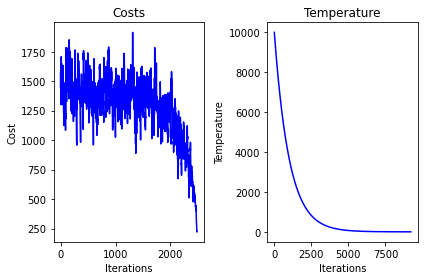

In [25]:
see_annealing(resultAnnealing[2], resultAnnealing[3])

([12, 32, 0, 35, 25, 3, 8, 13, 7, 4, 29, 6, 26, 18, 21, 10, 5, 22, 36, 31, 24, 1, 23, 9, 2, 27, 30, 34, 37, 20, 11, 15, 28, 14, 16, 38, 17, 39, 19, 33], 306)


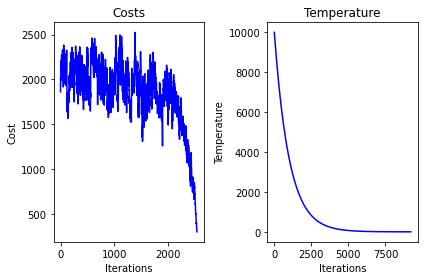

In [26]:
G = random_symmetric_graph(40)

resultAnnealing = simulated_annealing(G)
print(resultAnnealing[:2])
see_annealing(resultAnnealing[2], resultAnnealing[3])

### Testing Simulated Annealing Time Cost

#### Testing the time cost with random graphs.

In [27]:
pnts_n = []
pnts_t = []

n = 20
t0 = t1 = 0

retries = 10

while t1 - t0 < 2:  # in seconds; if it takes too long then stop testing
    G = random_symmetric_graph(n)
    average = 0
    for i in range(retries):
        t0 = time()
        simulated_annealing(G)
        t1 = time()
        average += t1 - t0
    # record time
    print(f"{n}\t{average/retries}")
    pnts_n.append(n)
    pnts_t.append(t1 - t0)
    n += 10

20	0.34699923992156984
30	0.43724062442779543
40	0.5419142007827759
50	0.6611186981201171
60	0.7667160272598267
70	0.8879432201385498
80	1.0076666831970216
90	1.0966886281967163
100	1.1886621475219727
110	1.2987979888916015
120	1.6287940979003905
130	1.5347157716751099
140	1.640572428703308
150	1.7366814851760863
160	1.8492676734924316
170	1.9697238445281982
180	2.116957974433899


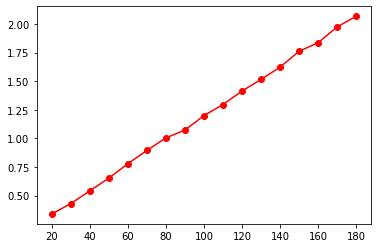

In [28]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

#### Testing with euclidean graph

In [29]:
pnts_n = []
pnts_t = []

n = 20
t0 = t1 = 0
retries = 10

while t1 - t0 < 2:  # in seconds; if it takes too long then stop testing
    G = random_euclidean_graph(n)
    average = 0
    for i in range(retries):
        t0 = time()
        simulated_annealing(G)
        t1 = time()
        average += t1 - t0
    # record time
    print(f"{n}\t{average/retries}")
    pnts_n.append(n)
    pnts_t.append(t1 - t0)
    n += 10

20	0.3382700204849243
30	0.45413668155670167
40	0.5728492498397827
50	0.6639371871948242
60	0.7761382579803466
70	0.8833122491836548
80	1.037361979484558
90	1.1543278455734254
100	1.241429042816162
110	1.3506295442581178
120	1.475076150894165
130	1.5747453689575195
140	1.6945055961608886
150	1.8488227128982544
160	1.9539114713668824
170	2.028790092468262


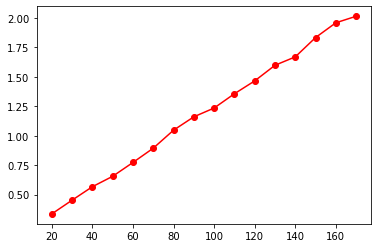

In [30]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

### Testing Simulated Annealing Quality

As in greedy quality will be estimated by comparing the current found solution to the "average length of a random cycle".
The average length of a random cycle is estimated in the same way as in greedy search testing:

$$\frac{\text{MAX_DISTANCE}}{2} \times n.$$

#### Testing with simmetric graph

In [31]:
pnts_n = []
pnts_q = []

retries = 10
n = 10
t0 = t1 = 0

while t1 - t0 < 2:
    average = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n
    sum_of_costs = 0
    for retry in range(retries):
        G = random_symmetric_graph(n)
        t0 = time()
        result = simulated_annealing(G)
        distance = result[1]
        t1=time()
        sum_of_costs += distance
    q = (sum_of_costs / retries) / expected_cycle_length
    pnts_n.append(n)
    pnts_q.append(q)
    print(f"{n}\t{q}")
    n += 10

10	0.358
20	0.22030000000000002
30	0.17426666666666665
40	0.16955
50	0.1582
60	0.17106666666666667
70	0.17391428571428572
80	0.17345
90	0.17193333333333335
100	0.1775
110	0.18110909090909091
120	0.18515
130	0.1909846153846154
140	0.19744285714285714
150	0.19930666666666666
160	0.204025
170	0.21591764705882352
180	0.20972222222222223


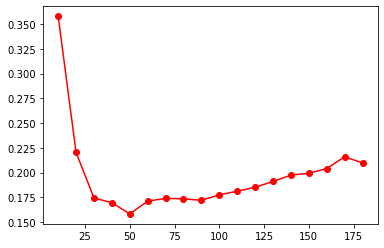

In [32]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

#### Testing with euclidean graph

In [33]:
pnts_n = []
pnts_q = []

retries = 10
n = 10
t0 = t1 = 0

while t1 - t0 < 2:
    average = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n
    sum_of_costs = 0
    for retry in range(retries):
        G = random_euclidean_graph(n)
        t0 = time()
        result = simulated_annealing(G)
        distance = result[1]
        t1=time()
        sum_of_costs += distance
    q = (sum_of_costs / retries) / expected_cycle_length
    pnts_n.append(n)
    pnts_q.append(q)
    print(f"{n}\t{q}")
    n += 10

10	0.5575006504467839
20	0.39339283871267605
30	0.32662353227232455
40	0.2865102486322731
50	0.2753977307618611
60	0.26304884120562705
70	0.26948774931354447
80	0.26715708496900914
90	0.2822215555089888
100	0.29142406204455773
110	0.2880986135211729
120	0.29603966990761765
130	0.2981672327916765
140	0.3047765904316881
150	0.31119463580071827
160	0.32155987516494405
170	0.32799442953558616


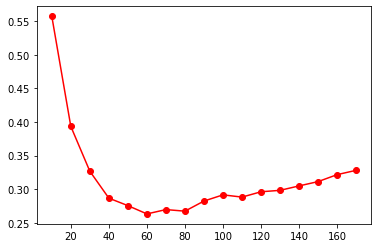

In [34]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

## Discussion

## GRASP

The idea is to:

* Consider vertex  0  as the start and the end point.
* Generate a random solution using a randomized greedy search algorithms
* Perform a local search on the temp solution
* Update the current solution with the new one if it gives a better results

**GRASP** is a multi-start or iterative metaheuristic, which utilizes iterations through two phases: construction of at least some randomized solution and a local search. Algorithm starts by constructing a randomized solution, using greedy random search, then it is necessary to apply an optimization to the solution, which in this case will be 2-opt algorithm. The 2-opt will be ran until the local minimum is found. The best solution is kept and presented as a result. (Resende and Ribeiro, 2019)

### Random Greedy Search pseudocode

**Input:** A graph (a list of nodes, each list containing list of distances from node to node)

**Output:** A randomly generated cycle, a list of costs for each edge in the cycle and the overall cost of the cycle

1. $H$ $\gets$ copy of $G$
2. $n$ $\gets$ len of $H$
3. $cities$ $\gets$ $list$ of a $range$ of $n$
4. $cycle$ $\gets$ $empty$ $list$
5. $city\gets 0$
6. **while** len of cities is not 0 **do**
7. $\quad$ $city$_$neighbours$$\gets$ $current$ $node$
8. $\quad$ $random$_$distance$$\gets$ $distance$ $to$ $random$ $neighbour$
9. $\quad$ **if** all neighbours cost inf **do**
10. $\qquad$ $random$_$distance$ $\gets$ $0$
11. $\qquad$ $stop$ $while$ $loop$
12. $\quad$ **end if**
13. $\quad$ $random$_$city$$\gets ramdom$_$distance$
14. $\quad$ $cycle$$\gets current city$
15. $\quad$ $remove$ $current$ $city$ $from$ $cities$ $list$
16. $\quad$ **for** all **n do**
17. $\qquad$ set current node $dist$ to $inf$
18. $\quad$ **end for**
19. $\quad$ **if** $random\_city$ $not$ 0 **do**
20. $\qquad$ $city$ $\gets$ $random\_city$
21. $\quad$ **end if**
22. **end while**
23. **return cycle, cost of G**

First while loop does $n$ cycles. Inside while loop we check if all of the neighbours are infinitely long which gives $n-1$ more computations. After that we set 1 neighbour's distance to be $infinitely$ long. This algorithm costs: $O(n^2)$

In [10]:
def greedy_rand_search(G):
    H = copy.deepcopy(G)
    n = len(H)
    cities = list(range(n))
    cycle = []
    arcCost = []
    city = 0
    while len(cities)>0:
        city_neighbours = H[city]
        random_distance = city_neighbours[randint(0, len(city_neighbours) - 1)]
        while isinf(random_distance):
            random_distance = city_neighbours[randint(0, len(city_neighbours) - 1)]
            if all_inf(city_neighbours):
                random_distance = oo
                break
        if not isinf(random_distance):
        	arcCost.append(random_distance)
        random_city = city_neighbours.index(random_distance)
        cycle.append(city)
        cities.remove(city)
        for i in range(n):
            H[city][i] = oo
            H[i][city] = oo
        if random_city != 0:
            city = random_city
    return (cycle, arcCost, cost(G, cycle))

def all_inf(list):
    return all(x == list[0] for x in list)

The code above illustrates the construction phase. On each iteration, it updates the solution by a random neighbour from the list. It keeps on updating the temporary solution until a path to the end node is formed. A randomized greedy construuction procedure is not always able to produce a feasable solution, thus we need to apply the repair procedure to the solution to achieve the feasibility.(Resende and Ribeiro, 2019)

### 2 opt algorithm

2-opt algorithm is a simple local search algorithm. Given a solution, it examines all possible solutions that are closely related to the original solution and finds the one with the lowest cost, if it exists. 2-opt algorithm works like any other k-opt algorithm - it deletes k number of edges from the original cycle and reconnects the resulting paths with k number of new edges (Marinakis et al. 2005).

Pseudocode for 2-opt algorithm:

**Input:** A graph (a list of nodes, each list containing list of distances from node to node), a randomly generated cycle, a list with costs for each edge in the cycle, the overall cost of the cycle.

**Output:** A new cycle, new cycle's cost.

1. $G$ $\gets$ graph
2. $cycle$ $\gets$ current solution
3. $cycleCost$ $\gets$ cost for current solution
4. $arcsCosts$ $\gets$ list of arc's costs for $cycle$
5. $dictionary$ $\gets$ **Make Dictionary** (arcs costs, cycle)
6. **for** x $\gets$ 0,..., n **do**
7. $\quad$ $biggestArcCost$ $\gets$ **BiggestKey**($dictionary$)
8. $\quad$ i, j $\gets$ $biggestArcCost$ nodes
9. $\quad$ **for** y **in** dictionary keys **do**
10. $\qquad$ $currentArcCost$ $\gets$ y
11. $\qquad$ $l, k$ $\gets$ $currentArcCost$ nodes
12. $\qquad$ $newCycle$ $\gets$ swap $i$ and $j$ in $cycle$
13. $\qquad$ $newCost$ $\gets$ cost of $newCycle$ in $G$
14. $\qquad$ **if** $newCost$ < $cycleCost$ **then**
15. $\qquad$$\quad$ $cycleCost$ $\gets$ $newCost$
16. $\qquad$$\quad$ $cycle$ $\gets$ $newCycle$
17. $\qquad$$\quad$ Delete $biggestArcCost$ and $currentArcCost$ from $dictionary$
18. $\qquad$$\quad$ Add $il$ and $jk$ costs to $dictionary$ with $il$ and $jk$ arcs as values
19. $\qquad$$\quad$ **end for**
20. **return** cycle, cycleCost

This algorithm works by creating a dictionary where edge (arc) cost is set as key, and it's nodes are set as values. 

In the first for loop it takes the biggest edge from dictionary and assigns it's nodes to variables. 

The next for loop iterates through all edges for the current solution, gets their cost and nodes. Then it swaps two nodes from the biggest in the list and the current edges, therefore deleting those edges and then reconnecting the two resulting paths in a different way, forming a new cycle. 

The cost is then calculated and if the cost is less than the original cost, the cycle is replaced by a new cycle, biggest and current edges deleted from dictionary and new ones added. The algorithm returns a modified cycle and cycle cost after n iterations.

The resulting algorithm has the cost of: $O(n^2)$

In [11]:
def local_2opt(G, cycle, arc_cost, cycle_cost):
    
    reordered_costs = make_dictionary(cycle, arc_cost)
    n = 10
    
    for x in range(0, n): 
        """get the first (biggest) arc from queue"""
        if(len(reordered_costs) <= 0): return(cycle, cycle_cost)
        """select biggest key from dictionary, dict doesnt have to be in order"""
        big_arc_cost = max(reordered_costs) #gets the biggest key from the dictionary
        i = reordered_costs[big_arc_cost][0] #biggest arc's from the queue starting node
        j = reordered_costs[big_arc_cost][1] #biggest arc's from the queue ending node
        
        for y in reordered_costs:
            """get crrent arc's nodes"""
            current_arc_cost = y
            l = reordered_costs[y][0] #current arc's from cycle starting node
            k = reordered_costs[y][1] #current arc's from cycle ending node
            
            new_cycle = swap_2opt(cycle, j, l)
            new_cost = cost(G, new_cycle)
            
            if(new_cost < cycle_cost 
               and G[i][l] not in reordered_costs #check if not in dictionary to not have 2 arcs for same key
               and G[j][k] not in reordered_costs
               and not isinf(G[i][l])             #check if not inf
               and not isinf(G[j][k])):
                
                cycle = new_cycle
                cycle_cost = new_cost
                
                del reordered_costs[big_arc_cost] #delete biggest dictionary entry
                del reordered_costs[current_arc_cost] #delete current arc from dictionary
                
                key = G[i][l] #size of new arc
                reordered_costs.setdefault(key, []) #add new arc to dictionary
                reordered_costs[key].append(i)
                reordered_costs[key].append(l)
                
                key = G[j][k]
                reordered_costs.setdefault(key, [])
                reordered_costs[key].append(j)
                reordered_costs[key].append(k)
                
                break
    return(cycle, cycle_cost)

def make_dictionary(cycle, arc_cost):
    """make a dictionary by connecting arc cost to its nodes"""
    dictionary = {}
    for i in range(0, len(arc_cost)):
        dictionary.setdefault(arc_cost[i], [])
        dictionary[arc_cost[i]].append(cycle[i])
        dictionary[arc_cost[i]].append(cycle[i+1])
    return dictionary
    
def swap_2opt(cycle, j, l):
    """form a new cycle"""
    a, b = cycle.index(j), cycle.index(l)
    cycle[a] = l
    cycle[b] = j
    return cycle

The **local search** phase usually improves the construction solution. It starts by iterating through the construction solution updating it with a better and more suitable neighbours for the problem to be solved. It terminates when no better solution is found in the neighbourhood.

### GRASP algorithm

Pseudocode for GRASP algorithm:

**Input:** A graph (a list of nodes, each list containing list of distances from node to node).

**Output:** A cycle through the graph, cycle's cost.

1. $graspCycle$ $\gets$ empty list
2. $graspCost$ $\gets$ infinity
3. $iteration$ $\gets$ 0
4. $n$ $\gets$ 10
5. **while** $iteration$ < $n$ **do**
6. $\quad$ $greedyCycle$, $greedyArcCost$, $greedyCost$ $\gets$ **greedyRandomSearch**($G$)
7. $\quad$ $bestCycle$, $bestCost$ $\gets$ **localSearch2opt**($G$, $greedyCycle$, $greedyArcCost$, $greedyCost$)
8. $\quad$ **if** $bestCost$ < $graspCost$ **do**
9. $\qquad$ $graspCycle$ $\gets$ $bestCycle$
10. $\qquad$ $graspCost$ $\gets$ $bestCost$
11. $\quad$ $iteration$ $\gets$ $iteration$ + 1
12. **return** $graspCycle$, $graspCost$

GRASP algorithm iterates n times in a while loop. Inside the while loop it runs two functions: greedyRandomSearch and localSearch2opt. Both of those functions have the cost of $O(n^2)$, thus, GRASP algorithm has the cost of: $O(n^3)$

In [12]:
def GRASP(G):
    
    grasp_cycle = list()
    grasp_cost = oo
    iteration = 0
    n = 10
    
    while iteration < n:

        greedy_cycle, greedy_arc_cost, greedy_cost = greedy_rand_search(G)
        best_cycle, best_cost = local_2opt(G, greedy_cycle, greedy_arc_cost, greedy_cost)

        if best_cost < grasp_cost:
            grasp_cycle = best_cycle
            grasp_cost = best_cost
            
        iteration += 1
        
    return (grasp_cycle, grasp_cost)

Lastly, the **GRASP** algorithm needs few more parameters to be set in order to start. The stopping criterion is described by the number of iterations. **Iteration** variable is defined in the code above, and is set to the number found through the trial of error which gave the best results. Although by increasing the iterations from this point most likely will not give new and better resuts, the quality of incumbent (the best current solution) may only improve. (Resende and Ribeiro, 2019)

### Testing GRASP algorithm

#### Testing time cost with symmetric graph

In [38]:
pnts_n = []
pnts_t = []

n = 20
t0 = t1 = 0

retries = 10

while t1 - t0 < 2:  # in seconds; if it takes too long then stop testing
    G = random_symmetric_graph(n)
    average = 0
    for i in range(retries):
        t0 = time()
        GRASP(G)
        t1 = time()
        average += t1 - t0
    # record time
    print(f"{n}\t{average/retries}")
    pnts_n.append(n)
    pnts_t.append(t1 - t0)
    n += 10

20	0.011960339546203614
30	0.02301058769226074
40	0.039058899879455565
50	0.05219433307647705
60	0.07300066947937012
70	0.09411044120788574
80	0.12143008708953858
90	0.15394983291625977
100	0.19032256603240966
110	0.22479710578918458
120	0.2620081901550293
130	0.31476151943206787
140	0.34917733669281004
150	0.41359174251556396
160	0.46638777256011965
170	0.5147627115249633
180	0.5713319301605224
190	0.6427867889404297
200	0.7015888452529907
210	0.7762319326400757
220	0.8467791080474854
230	0.9055338859558105
240	0.9732921361923218
250	1.0639024019241332
260	1.139643907546997
270	1.2038066148757935
280	1.289610242843628
290	1.355893850326538
300	1.4332266092300414
310	1.5308463096618652
320	1.6290194749832154
330	1.700825047492981
340	1.8003236532211304
350	1.8943529844284057
360	1.9954670667648315
370	2.0756704807281494


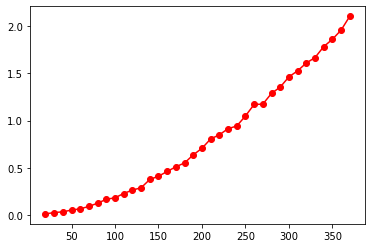

In [39]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

#### Testing time cost with euclidean graph

In [40]:
pnts_n = []
pnts_t = []

n = 20
t0 = t1 = 0
retries = 10

while t1 - t0 < 2:  # in seconds; if it takes too long then stop testing
    G = random_euclidean_graph(n)
    average = 0
    for i in range(retries):
        t0 = time()
        GRASP(G)
        t1 = time()
        average += t1 - t0
    # record time
    print(f"{n}\t{average/retries}")
    pnts_n.append(n)
    pnts_t.append(t1 - t0)
    n += 10

20	0.010940790176391602
30	0.018860578536987305
40	0.03416554927825928
50	0.05021965503692627
60	0.06335253715515136
70	0.08822095394134521
80	0.10474929809570313
90	0.1300647020339966
100	0.14816744327545167
110	0.1655170202255249
120	0.19696943759918212
130	0.23957500457763672
140	0.2740356683731079
150	0.3018594264984131
160	0.33489649295806884
170	0.38494305610656737
180	0.40115809440612793
190	0.4345553874969482
200	0.49178693294525144
210	0.568126916885376
220	0.5860283613204956
230	0.5744994640350342
240	0.7370120763778687
250	0.7858534812927246
260	0.817366623878479
270	0.8364510059356689
280	0.9633323192596436
290	1.0009158611297608
300	0.9985369443893433
310	1.1699926137924195
320	1.2775695323944092
330	1.269557738304138
340	1.3704527616500854
350	1.5029585123062135
360	1.4838318347930908
370	1.5452507734298706
380	1.6057060480117797
390	1.7777916193008423
400	1.9185084581375123


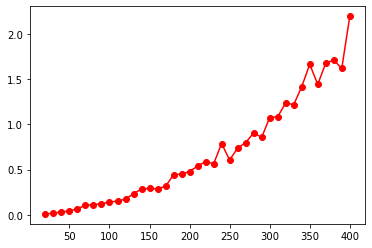

In [41]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

#### Testing quality with symmetric graph

In [42]:
pnts_n = []
pnts_q = []

retries = 10
n = 10
t0 = t1 = 0

while t1 - t0 < 2:
    average = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n
    sum_of_costs = 0
    for retry in range(retries):
        G = random_symmetric_graph(n)
        t0 = time()
        result = GRASP(G)
        distance = result[1]
        t1=time()
        sum_of_costs += distance
    q = (sum_of_costs / retries) / expected_cycle_length
    pnts_n.append(n)
    pnts_q.append(q)
    print(f"{n}\t{q}")
    n += 10

10	0.569
20	0.6307999999999999
30	0.6746
40	0.7533
50	0.77164
60	0.7829666666666667
70	0.8107428571428571
80	0.8261000000000001
90	0.828911111111111
100	0.8282200000000001
110	0.8704545454545455
120	0.8652166666666667
130	0.8696461538461538
140	0.8657285714285715
150	0.87936
160	0.89
170	0.9031411764705882
180	0.9119888888888888
190	0.9113368421052632
200	0.9333299999999999
210	0.9190857142857143
220	0.9231363636363636
230	0.9220956521739131
240	0.9342916666666666
250	0.94456
260	0.9531461538461539
270	0.9452814814814814
280	0.95265
290	0.942503448275862
300	0.9588266666666666
310	0.9540838709677419
320	0.9490125
330	0.9599696969696969
340	0.9608058823529412
350	0.9586685714285714
360	0.9605333333333332


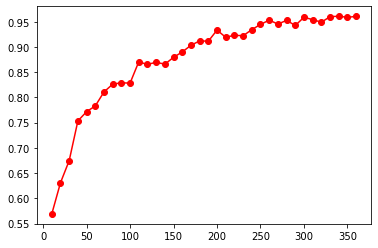

In [43]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

#### Testing quality with euclidean graph

In [44]:
pnts_n = []
pnts_q = []

retries = 10
n = 10
t0 = t1 = 0

while t1 - t0 < 2:
    average = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n
    sum_of_costs = 0
    for retry in range(retries):
        G = random_euclidean_graph(n)
        t0 = time()
        result = GRASP(G)
        distance = result[1]
        t1=time()
        sum_of_costs += distance
    q = (sum_of_costs / retries) / expected_cycle_length
    pnts_n.append(n)
    pnts_q.append(q)
    print(f"{n}\t{q}")
    n += 10

10	0.7323754612353652
20	0.7883396351312638
30	0.7663761396224671
40	0.8461607710857059
50	0.8523612091704981
60	0.8546101725636198
70	0.8589545036847291
80	0.8904516587897613
90	0.9157666656851196
100	0.923911551361335
110	0.9135934066440011
120	0.9285067182171146
130	0.9480079099550776
140	0.9332564309672532
150	0.9349873716737507
160	0.9582911258463465
170	0.9601955732035
180	0.9492377827185923
190	0.9708298831298813
200	0.966421543289328
210	0.9538815425959576
220	0.9822630835611738
230	0.9586318776515456
240	0.9775854119591391
250	0.9773696178733364
260	0.9849719953515117
270	0.9885159022954187
280	0.9900176181957595
290	0.9796741098985735
300	0.9809758594986469
310	0.9862162676553272
320	0.997826011155889
330	0.9877326842366982
340	0.9953288508125753
350	1.0020919538905606
360	0.9967845705044855
370	0.9930445124047593
380	0.9931905435406301
390	0.9956104692145167


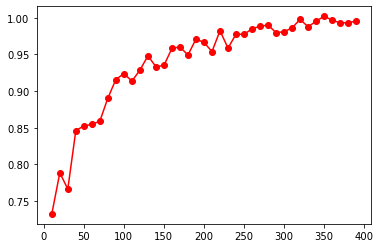

In [45]:
plt.plot(pnts_n, pnts_q, 'ro-')
plt.show()

## Comparing GRASP, SA and Greedy Nearest Neighbour

### Testing for time and costs of found solutions

#### Test with symmetric graphs

In [16]:
pnts_cost_greedy, pnts_cost_grasp, pnts_cost_sa = [], [], []
pnts_time_greedy, pnts_time_grasp, pnts_time_sa = [], [], []
max_cities = 2500

def test_heuristics():
    print("Cities\tGreedy_c\tGRASP_c\t\tSA_c\t\tGreedy_t\tGRASP_t\t\tSA_t")
    iteration = 0
    for cities in range(100, max_cities+1, 100):
        G = random_symmetric_graph(cities)
        # Greedy
        t0 = time()
        path, cost = greedy_nearest_neighbours(G)
        t1 = time()
        pnts_time_greedy.append(round(t1- t0, 2))
        pnts_cost_greedy.append(cost)
        # GRASP
        t0 = time()
        path, cost = GRASP(G)
        t1 = time()
        pnts_time_grasp.append(round(t1 - t0, 2))
        pnts_cost_grasp.append(cost)
        # SA
        t0 = time()
        sa_solution = simulated_annealing(G)
        t1 = time()
        pnts_time_sa.append(round(t1 - t0, 2))
        pnts_cost_sa.append(sa_solution[1])
        # Finally print
        print(f"{cities:4}\t{pnts_cost_greedy[iteration]:4}\t\t{pnts_cost_grasp[iteration]:6}\t\t{pnts_cost_sa[iteration]:5}", end='')
        print(f"\t\t{pnts_time_greedy[iteration]:8}\t{pnts_time_grasp[iteration]:7}\t\t{pnts_time_sa[iteration]:5}")
        iteration += 1
print("\t" * 5 + "Testing with symmetric graph", end="\n\n")
test_heuristics()

					Testing with symmetric graph

Cities	Greedy_c	GRASP_c		SA_c		Greedy_t	GRASP_t		SA_t
 100	 611		  4273		  890		    0.02	    0.4		 1.94
 200	 636		  8946		 2099		    0.04	   1.13		 3.66
 300	 812		 14648		 3741		     0.1	   2.26		 5.82
 400	 891		 19434		 5914		    0.25	   4.15		 7.59
 500	 983		 24637		 7948		    0.39	   5.86		10.64
 600	1149		 29211		10664		    0.52	   7.94		 10.9
 700	1181		 34911		11944		    0.58	  13.68		13.03
 800	1167		 38488		15032		    0.73	  13.27		15.03
 900	1285		 44124		17963		    0.94	  17.68		17.01
1000	1436		 48900		19733		    1.23	  20.39		20.26
1100	1517		 53942		24421		    1.45	  26.01		23.06
1200	1716		 58826		26515		    1.92	  32.21		23.24
1300	1838		 63919		28951		    1.97	  32.73		25.03
1400	1852		 67657		32505		    2.26	  37.17		27.06
1500	1998		 74223		37714		    2.66	  46.87		29.22
1600	2064		 78864		39161		    2.99	  52.61		31.11
1700	2116		 83195		44196		    3.34	  55.84		33.36
1800	2325		 88865		45868		    3.75	  62.61		35.09
1900	2324		

#### Test with euclidean graphs

In [17]:
pnts_cost_greedy_e, pnts_cost_grasp_e, pnts_cost_sa_e = [], [], []
pnts_time_greedy_e, pnts_time_grasp_e, pnts_time_sa_e = [], [], []

def test_heuristics():
    print("Cities\tGreedy_c\tGRASP_c\t\tSA_c\t\tGreedy_t\t\tGRASP_t\t\tSA_t")
    iteration = 0
    for cities in range(100, max_cities+1, 100):
        G = random_euclidean_graph(cities)
        # Greedy
        t0 = time()
        path, cost = greedy_nearest_neighbours(G)
        t1 = time()
        pnts_time_greedy_e.append(round(t1- t0, 2))
        pnts_cost_greedy_e.append(round(cost, 2))
        # GRASP
        t0 = time()
        path, cost = GRASP(G)
        t1 = time()
        pnts_time_grasp_e.append(round(t1 - t0, 2))
        pnts_cost_grasp_e.append(round(cost, 2))
        # SA
        t0 = time()
        sa_solution = simulated_annealing(G)
        t1 = time()
        pnts_time_sa_e.append(round(t1 - t0, 2))
        pnts_cost_sa_e.append(round(sa_solution[1], 2))
        # Finally print
        print(f"{cities:4}\t{pnts_cost_greedy_e[iteration]:7}\t\t{pnts_cost_grasp_e[iteration]:9}\t{pnts_cost_sa_e[iteration]:9}", end='')
        print(f"\t\t{pnts_time_greedy_e[iteration]:4}\t\t{pnts_time_grasp_e[iteration]:5}\t\t{pnts_time_sa_e[iteration]:5}")
        iteration += 1
print("\t" * 5 + "Testing with euclidean graph", end="\n\n")
test_heuristics()

					Testing with euclidean graph

Cities	Greedy_c	GRASP_c		SA_c		Greedy_t		GRASP_t		SA_t
 100	 986.52		  4583.49	  1415.46		0.05		  0.3		 1.86
 200	1410.71		  9302.67	  3274.24		0.04		 0.75		 3.57
 300	1640.59		 14569.62	  6002.19		 0.1		 1.58		 6.24
 400	1956.45		 19789.22	  8666.61		0.27		 2.78		 8.33
 500	2108.67		  25286.0	 12002.82		0.33		 3.96		 9.27
 600	2291.73		 29377.18	 14565.07		0.44		 5.82		11.61
 700	2536.53		 35014.38	 18315.94		 0.6		 8.08		13.28
 800	2561.31		 39975.84	 21264.83		0.79		12.74		 15.6
 900	2838.82		 45656.81	 24697.64		 1.0		13.95		17.74
1000	2932.28		 51101.29	 28959.49		1.28		15.19		19.67
1100	 3050.5		  55489.0	 32769.61		1.51		18.66		22.18
1200	3170.39		 61132.31	 36197.66		1.81		22.16		 24.6
1300	3350.96		 65831.74	 41231.95		2.55		27.83		26.35
1400	3514.59		 71212.34	 44590.93		2.47		28.87		 29.2
1500	3596.57		 77136.63	 48945.68		2.86		35.24		 33.0
1600	3578.17		 81874.07	 53927.17		3.72		40.68		33.57
1700	3857.34		 86968.63	 58175.98		3.69		41.76

### Comparing costs and times of solutions

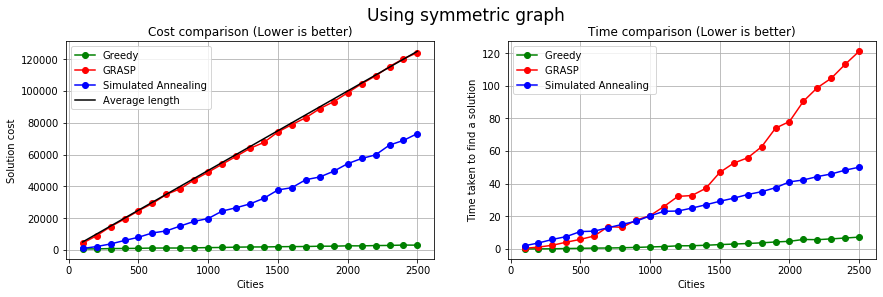

In [18]:
citiesList = list(range(100, max_cities + 1, 100))
pnts_expected_distance = [(MAX_DISTANCE/2)*n for n in citiesList]

plt.figure()
costPlot = plt.subplot(121, xlabel='Cities', ylabel='Solution cost')
p1 = plt.plot(citiesList, pnts_cost_greedy, 'go-', label="Greedy")
p2 = plt.plot(citiesList, pnts_cost_grasp, 'ro-', label="GRASP")
p3 = plt.plot(citiesList, pnts_cost_sa, 'bo-', label="Simulated Annealing")
p4 = plt.plot(citiesList, pnts_expected_distance, 'k-', label="Average length")
costPlot.legend(loc='best')
plt.title('Cost comparison (Lower is better)')
plt.grid(True)

timePlot = plt.subplot(122, xlabel='Cities', ylabel='Time taken to find a solution')
p1 = plt.plot(citiesList, pnts_time_greedy, 'go-', label="Greedy ")
p2 = plt.plot(citiesList, pnts_time_grasp, 'ro-', label="GRASP ")
p3 = plt.plot(citiesList, pnts_time_sa, 'bo-', label="Simulated Annealing ")
timePlot.legend(loc='best')
plt.title('Time comparison (Lower is better)')
plt.grid(True)
plt.subplots_adjust(right = 2)
plt.suptitle("Using symmetric graph", x=1.05, y=1, verticalalignment='top', fontsize = 17)
plt.show()

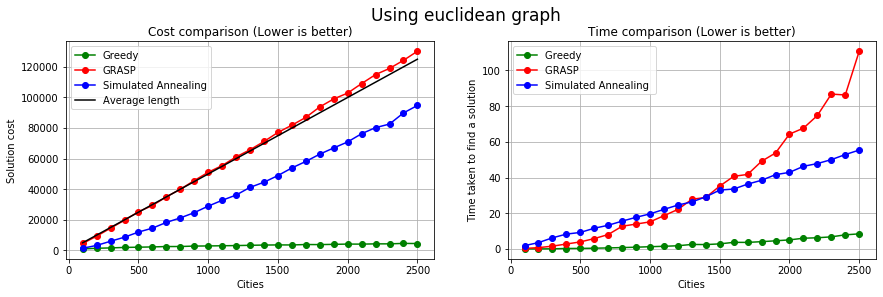

In [19]:
citiesList = list(range(100, max_cities + 1, 100))

plt.figure()
costPlot = plt.subplot(121, xlabel='Cities', ylabel='Solution cost')
p1 = plt.plot(citiesList, pnts_cost_greedy_e, 'go-', label="Greedy")
p2 = plt.plot(citiesList, pnts_cost_grasp_e, 'ro-', label="GRASP")
p3 = plt.plot(citiesList, pnts_cost_sa_e, 'bo-', label="Simulated Annealing")
p4 = plt.plot(citiesList, pnts_expected_distance, 'k-', label="Average length")
costPlot.legend(loc='best')
plt.title('Cost comparison (Lower is better)')
plt.grid(True)

timePlot = plt.subplot(122, xlabel='Cities', ylabel='Time taken to find a solution')
p1 = plt.plot(citiesList, pnts_time_greedy_e, 'go-', label="Greedy ")
p2 = plt.plot(citiesList, pnts_time_grasp_e, 'ro-', label="GRASP ")
p3 = plt.plot(citiesList, pnts_time_sa_e, 'bo-', label="Simulated Annealing ")
timePlot.legend(loc='best')
plt.title('Time comparison (Lower is better)')
plt.grid(True)
plt.suptitle("Using euclidean graph", x=1.05, y=1, verticalalignment='top', fontsize = 17)
plt.subplots_adjust(right = 2)
plt.show()

# Discussion

- All methods perform worse on euclidean graphs.
- Both, Simulated Annealing (SA) and GRASP implementations have a significant increase in time and cycle cost as more and more cities get added to the graph, seen by a steep slope in result graphs.
- GRASP has the worst cost performance, always producing a solution with about the average cost and being the slowest with graphs of >1000 cities.
- Greedy Nearest Neighbour heuristic performs the best producing significantly better cost and time measures for both Euclidean and symmetric graphs.

For $1\leq cities < 1200$:

- Time-wise, GRASP implementation outperforms Simulated Annealing implementation by a slight margin. 
- The cost of both GRASP and SA increase, with GRASP producing about the average and SA producing just below the average cost.

For $1200\leq cities \leq 2500$:

- As number of cities increases, all solutions generally perform worse.
- Greedy Nearest Neighbour is the most efficient time-wise due to lowest time complexity and produces remarkably better cost.
- SA algorithm starts outperforming GRASP implementation time-wise.
- The cost comparison between GRASP and SA is generally the same as with graphs of $1\leq cities < 1200$ cities.

# Conclusion

- Greedy Nearest Neighbour algorithm outperforms both GRASP and SA algorithms by a big margin.
- SA can be useful when the city count is around 100, however for bigger problems adjustment in temperature is needed.
- GRASP algorithm preforms quite good time-wise with small graphs. However, the time it takes to find an optimal solution significantly rises with bigger graphs.
- SA starts outperforming GRASP time-wise on big graphs.
- GRASP performs very poorly quality-wise. The produced cycle cost is always around the average line which is very bad.
- The meta-heuristics implementations used in this project provided no significant improvement in time or quality compared to Greedy Nearest Neighbour approximation algorithm

# References

* Garey, S. and Johnson, D. (1979)
**Computers and Intractability: A Guide to the Theory of NP-Completeness.**
Freeman.

* Hoos, H. and Stutzler, T. (2005)
**Stochastic Local Search: Foundations and Applications.**
Morgan Kaufmann.

* Sipser, M. (2013).
**Introduction to the theory of computation**
(3rd international ed.). Cengage Learning.

* Kirkpatrick, S.; Gelatt, C. D.; Vecchi, M. P. (1983)
**Optimization by Simulated Annealing**
Science, Volume 220, Issue 4598, pp. 671-680

* Resende, M. and Ribeiro, C. (2019).
**Greedy Randomized Adaptive Search Procedures: Advances and Extensions.[online]**
Available at: http://www.dcc.ic.uff.br/~celso/artigos/resende-ribeiro-GRASP-HMH3.pdf [Accessed 26 Mar. 2020].

* Marinakis, Y., Migdalas, A. and Pardalos, P. (2005) 
**"Expanding Neighborhood GRASP For The Traveling Salesman Problem".** Computational Optimization And Applications 32 (3), 231-257